In [10]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import scipy.stats as st
from collections import OrderedDict


In [11]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_


In [22]:
def conf_interval_left(data, confidence=95):
    # return st.t.interval(confidence/100.0, len(data)-1, loc=np.mean(data), scale=st.sem(data))[0]
    return sns.utils.ci(sns.algorithms.bootstrap(data, n_boot=1000), which=confidence)[0]

def conf_interval_right(data, confidence=95):
    return sns.utils.ci(sns.algorithms.bootstrap(data, n_boot=1000), which=confidence)[1]
    # return st.t.interval(confidence/100.0, len(data)-1, loc=np.mean(data), scale=st.sem(data))[1]


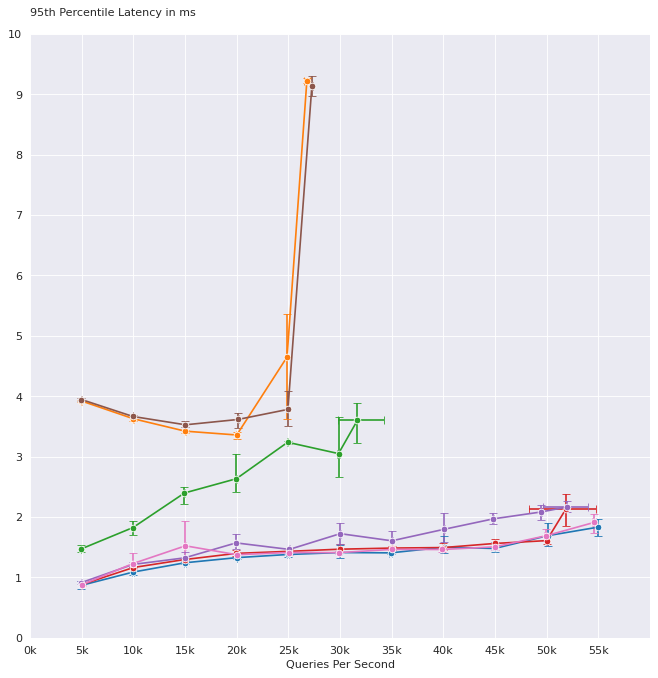

In [26]:
def plot(sb=False): 
    fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
    sns.set_style("darkgrid")
    plt.text(0, 10.3, "95th Percentile Latency in ms")
    plt.ylabel("")
    plt.xlabel("Queries Per Second")
    plt.xlim([0, 60000])
    plt.ylim([0, 10])
    plt.yticks(range(0, 11))
    plt.xticks(range(0, 60000, 5000))
    
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x_val, tick_pos: "{:.0f}k".format(x_val/1000)))
    
    for subdir in os.scandir("./results"): 
        all_files = glob.glob(os.path.join(subdir.path, "*.out"))
        dfs = (pd.read_csv(file, delim_whitespace=True) for file in all_files)
        data = pd.concat(dfs, ignore_index=True)
        data["p95"] = data["p95"].divide(1000.0)
        
        data_agg = data[["target", "p95", "QPS"]].groupby("target", as_index=False).agg([
            ('mean', np.mean),
            ('conf_interval_left', conf_interval_left),
            ('conf_interval_right', conf_interval_right),
        ]).reset_index()
        
        data_agg = data_agg[data_agg["QPS"]["mean"] > data_agg["target"] - 5000]
            
        if sb:
            sns.lineplot(data=data, x=data["target"], y=data["p95"],
                             label=subdir.name,
                             marker='o',
                             err_style="bars",
                             err_kws={'capsize':4, 'capthick':1.3, 'elinewidth': 1.5},
                             ax=ax
                            )
        else:   
            # xerr=[data_agg["QPS"]["mean"] - data_agg["QPS"]["p2.5"], data_agg["QPS"]["p97.5"] - data_agg["QPS"]["mean"]]
            xerr=[data_agg["QPS"]["mean"] - data_agg["QPS"]["conf_interval_left"], data_agg["QPS"]["conf_interval_right"] - data_agg["QPS"]["mean"]]
            # yerr=[data_agg["p95"]["mean"] - data_agg["p95"]["p2.5"], data_agg["p95"]["p97.5"] - data_agg["p95"]["mean"]]
            yerr=[data_agg["p95"]["mean"] - data_agg["p95"]["conf_interval_left"], data_agg["p95"]["conf_interval_right"] - data_agg["p95"]["mean"]]
            ax.errorbar(data_agg["QPS"]["mean"], data_agg["p95"]["mean"], 
                         xerr=xerr,
                         yerr=yerr,
                         capsize=4,
                         capthick=1.3,
                         elinewidth=1.5,
                         fmt='o-',
                         mec='white',
                         mew=.75,
                        )
    plt.show()
    plt.savefig('task1.pdf', bbox_inches='tight')
    plt.close()
    
plot(sb=False)
# plot(sb=True)

In [1]:

fig, ax = plt.subplots()
ax.errorbar([1,2,3], [4,5,6], 
                    xerr=[[0.5, 0.5, 0.5], [1,2,3]], 
                    yerr=[1,2,3], 
                    fmt='o')
plt.show()


NameError: name 'plt' is not defined